<a href="https://colab.research.google.com/github/shadab4150/Deep-Learning-Classifiers/blob/master/Toxic_comment_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from fastai.text import *
from fastai import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.metrics import roc_auc_score
gc.collect()

0

In [5]:
!unzip '/content/drive/My Drive/Dataset/toxic_text.zip' -d '/content/text/'

Archive:  /content/drive/My Drive/Dataset/toxic_text.zip
  inflating: /content/text/train.csv  
  inflating: /content/text/sample_submission.csv  
  inflating: /content/text/test_labels.csv  
  inflating: /content/text/test.csv  


In [0]:
train = pd.read_csv('/content/text/train.csv')
test = pd.read_csv('/content/text/test.csv')
test_lb = pd.read_csv('/content/text/test_labels.csv')
sample = pd.read_csv('/content/text/sample_submission.csv')

In [46]:
train.drop(['id'],axis=1,inplace=True)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [39]:
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,No,No,No,No,No,No
1,D'aww! He matches this background colour I'm s...,No,No,No,No,No,No
2,"Hey man, I'm really not trying to edit war. It...",No,No,No,No,No,No
3,"""\nMore\nI can't make any real suggestions on ...",No,No,No,No,No,No
4,"You, sir, are my hero. Any chance you remember...",No,No,No,No,No,No


In [40]:
train.dtypes

comment_text     object
toxic            object
severe_toxic     object
obscene          object
threat           object
insult           object
identity_hate    object
dtype: object

In [15]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
train_lm = pd.concat([train[['comment_text']],test[['comment_text']]])
print("total rows : " + str(train_lm.shape[0]))
print("--"*80)
train_lm.head()

total rows : 312735
----------------------------------------------------------------------------------------------------------------------------------------------------------------


,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


In [18]:
sample.head(2)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5


In [0]:
bs = 128
path = Path('/content/')

In [0]:
!cp '/content/drive/My Drive/Dataset/ftenc.pth' '/content/models'

In [0]:
!cp '/content/drive/My Drive/Dataset/data_clf.pkl' '/content/'
!cp '/content/drive/My Drive/Dataset/toxic_lm.pkl' '/content/'
!cp '/content/drive/My Drive/Dataset/toxic_bwd.pkl' '/content/'

# Langua Model for toxic comments

In [30]:
data_lm = (TextList.from_df(train_lm,path,cols='comment_text')
                  .split_by_rand_pct(0.15,seed=42)
                  .label_for_lm()
                  .databunch(bs=bs,num_workers=1))

In [0]:
data_lm.save('toxic_lm.pkl')

# Backwards language model data_block for ensemble

In [36]:
data_lm_bwd = (TextList.from_df(train_lm,path,cols='comment_text')
                  .split_by_rand_pct(0.15,seed=42)
                  .label_for_lm()
                  .databunch(bs=bs,num_workers=1,backwards=True))

In [0]:
data_lm_bwd.save('toxic_bwd.pkl')

In [32]:
data_lm.show_batch(rows=5)

idx,text
0,""" xxup -i think the references may need tidying so that they are all in the exact same format ie date format etc . i can do that later on , if no - one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know . \n \n xxmaj there appears to be a backlog"
1,"i am notifying you , together with appropriate link here , that xxmaj harold xxmaj xxunk now sits atop the xxup fac pile , awaiting judgement . i hope the cruise went / is going well , and look forward to your comments . xxbos xxmaj sorry i left out the heading . xxmaj it may be clearer now . xxup btw , if you respond to me , leave"
2,"mountain xxmaj artillery xxmaj regiment ( xxmaj italy ) xxbos xxmaj you recent addition to xxmaj super xxmaj bowl xxup xl \n \n xxmaj for your information : i removed the following addition you made to this article : \n \n xxmaj in a recent interview with the xxup nfl xxmaj network , a referee from xxmaj super xxmaj bowl xxup xl has defended many of the calls"
3,"rajus article by adding information and protect it from vandalism . xxmaj thank xxmaj you xxunk xxbos "" \n \n xxmaj request for xxmaj comments \n \n xxmaj there is an rfc on the question of using "" "" xxmaj religion : xxmaj none "" "" vs. "" "" xxmaj religion : xxmaj none ( atheist ) "" "" in the infobox on this and other similar pages"
4,"barnstar xxmaj thank you for deciding to unblock me , i am very greatful and i hope i will be able to improve and contribute to xxmaj wikipedia ; however , xxmaj what is happening about the "" "" adoption "" "" process ? "" xxbos xxmaj to add a wikilink to an article , edit the page and add a double pair of brackets around the title of the"


In [0]:
data_lm = load_data(path, 'toxic_lm.pkl', bs=bs)

# Using transfer learning 
* A pretrained **AWD_LSTM** which was trained on  english wikipedia articles

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM,metrics=[accuracy,Perplexity()],drop_mult=0.4).to_fp16()

epoch,train_loss,valid_loss,accuracy,perplexity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


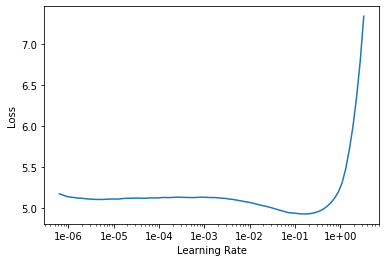

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
gc.collect()

7314

In [0]:
lr = 1e-2

In [11]:
learn.fit_one_cycle(4,lr,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.986051,3.851040,0.321082,47.041988,13:50
1,3.939698,3.795444,0.328441,44.497978,13:57
2,3.785719,3.716726,0.336835,41.129478,13:58
3,3.702214,3.689704,0.339730,40.032993,13:58


In [0]:
learn.save('model1')
learn.save_encoder('ftenc')

In [0]:
data_lm.vocab.save('vocab.pkl')

In [71]:
data_clf = None
gc.collect()

116

# Classifier

In [0]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']

In [0]:
test_clf = TextList.from_df(test,path,cols='comment_text',vocab=data_lm.vocab)

In [118]:
data_clf = (TextList.from_df(train,path,vocab=data_lm.vocab,cols='comment_text')
                   .split_by_rand_pct(0.15,seed=42)
                   .label_from_df(cols=label_cols ,label_cls = MultiCategoryList, one_hot = True)
                   #.label_from_df(cols= label_cols , classes=label_cols) # Another Way
                   .add_test(test_clf)
                   .databunch(bs=bs,num_workers=1))
                   


In [56]:
data_clf.show_batch(rows=5)

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene
"xxbos xxup nate , xxup you xxup are xxup fucking xxup god xxup damn xxup fired ! xxup you xxup are xxup fucking xxup fired ! xxup you xxup are xxup fucking xxup fired ! xxup nate , xxup you xxup are xxup fucking xxup god xxup damn xxup fired ! xxup you xxup are xxup fucking xxup fired ! xxup you xxup are xxup fucking xxup fired ! xxup",toxic;severe_toxic;obscene;insult
"xxbos "" \n \n xxmaj some historical references to the story of the xxmaj janjua xxmaj rajputs / sitush stop fucking with our article you gay hindu \n \n ' xxmaj some historical references to the story of the xxmaj janjua xxmaj rajputs ... xxunk text . \n xxmaj predating all that is related below , the xxmaj xxunk ancestors of xxmaj janjuas were known historically for",
"xxbos xxmaj hi again , below is the edit i would like to make to the wiki page about me . xxmaj pretty much all of the information is a matter of public record and pretty easily verifiable . xxmaj this is the same bio that is used by the university at which i am a professor . xxmaj in fact , i think that s how the edit may",
"xxbos "" \n \n xxmaj origin \n xxmaj parts of this article particularly the "" "" xxmaj origin xxmaj section "" "" not only failed to cite reliable sources , it also left out material facts as regards to the true origin of xxmaj takrur ( also spelt xxmaj xxunk ) . xxmaj in this regard , it totally left out the history of the xxmaj serer people",


In [0]:
data_clf.save('data_clf.pkl')
!cp '/content/data_clf.pkl' '/content/drive/My Drive/Dataset/'

In [0]:
data_clf = load_data(path, 'data_clf.pkl', bs=bs)

In [121]:
train.shape

(159571, 7)

In [120]:
len(data_clf.test_ds),test.shape[0],len(data_clf.train_ds),len(data_clf.valid_ds)

(153164, 153164, 135636, 23935)

In [0]:
#aucroc = AUROC()

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [0]:
clf = text_classifier_learner(data_clf,AWD_LSTM, drop_mult=0.3, metrics=[acc_02]).to_fp16()
clf.load_encoder('ftenc');

# Model Summary

In [61]:
clf.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [50, 400]            0          False     
______________________________________________________________________
RNNDropout           [50, 1152]           0          False     
______________________________________________________________________
RNNDropout           [50, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


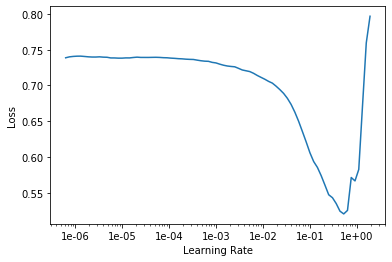

In [63]:
clf.lr_find()
clf.recorder.plot()

In [123]:
gc.collect()

0

In [0]:
lr_c = 1e-2

In [80]:
clf.fit_one_cycle(4,lr_c,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.114798,0.090815,0.938158,01:10
1,0.082539,0.068826,0.965652,01:19
2,0.074514,0.067699,0.958326,01:27
3,0.072741,0.066024,0.961112,01:26


In [0]:
clf.save('clfmodel')
clf.load('clfmodel')
clf.unfreeze()

In [0]:
clf.lr_find()
clf.recorder.plot()

In [0]:
clf.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [129]:
len(data_clf.test_ds)

153164

In [130]:
preds, target = clf.get_preds(DatasetType.Test, ordered=True)

In [131]:
len(preds)

153164

In [0]:
res = np.array(preds)

In [133]:
test_id = test['id'].values
submission = pd.DataFrame({'id': test_id})
submission = pd.concat([submission, pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1)

submission.to_csv('submission321.csv', index=False)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.847968,0.140808,0.673084,8.137364e-02,0.585871,0.140690
1,0000247867823ef7,0.000568,0.000004,0.000175,1.482358e-06,0.000086,0.000008
2,00013b17ad220c46,0.002463,0.000019,0.000773,8.315280e-07,0.000381,0.000030
3,00017563c3f7919a,0.000707,0.000009,0.000357,1.618758e-05,0.000147,0.000009
4,00017695ad8997eb,0.020844,0.000222,0.006719,2.115289e-04,0.003839,0.000149


In [134]:
submission.dtypes

id                object
toxic            float32
severe_toxic     float32
obscene          float32
threat           float32
insult           float32
identity_hate    float32
dtype: object

In [88]:
sample.shape,submission.shape

((153164, 7), (153164, 7))

In [135]:
submission.isna().sum()

id               0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [0]:
submission.fillna(value=0.34,inplace=True)
submission.to_csv('submission324.csv', index=False)